# AIS Vessel Trajectory Prediction - Visual Analysis

This notebook provides a complete visual walkthrough of our vessel H3 cell prediction system:

1. **Raw Vessel Data Exploration** - See what data we have
2. **H3 Grid Visualization** - Understand the spatial framework 
3. **Feature Engineering** - Transform raw data into ML features
4. **Model Training & Results** - Train and evaluate our predictor
5. **Prediction Visualization** - See model predictions on maps

Let's start exploring! 🚢🗺️

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import h3
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add our source code to path
sys.path.append('../src')

from features.vessel_h3_tracker import VesselH3Tracker
from features.vessel_features import VesselFeatureExtractor

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("📦 All libraries imported successfully!")
print("🚀 Ready to explore vessel trajectory prediction!")

📦 All libraries imported successfully!
🚀 Ready to explore vessel trajectory prediction!


## 1. Raw Vessel Data Exploration 🛳️

Let's start by loading and exploring our raw AIS vessel data to understand what we're working with.

In [2]:
# Load raw vessel data
print("📊 Loading raw vessel data...")
df = pd.read_pickle('../data/raw/ais_cape_data_2024.pkl')

print(f"✅ Loaded {len(df):,} AIS records")
print(f"📅 Date range: {df['mdt'].min()} to {df['mdt'].max()}")
print(f"🚢 Unique vessels: {df['imo'].nunique()}")
print(f"📍 Geographic bounds:")
print(f"   Latitude: {df['lat'].min():.3f} to {df['lat'].max():.3f}")
print(f"   Longitude: {df['lon'].min():.3f} to {df['lon'].max():.3f}")

# Show sample data
print("\n📋 Sample data:")
display(df[['imo', 'mdt', 'lat', 'lon', 'speed', 'heading', 'destination']].head())

📊 Loading raw vessel data...
✅ Loaded 14,551,346 AIS records
📅 Date range: 2024-01-01 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
🚢 Unique vessels: 1794
📍 Geographic bounds:
   Latitude: -74.186 to 80.755
   Longitude: -180.000 to 180.000

📋 Sample data:
✅ Loaded 14,551,346 AIS records
📅 Date range: 2024-01-01 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
🚢 Unique vessels: 1794
📍 Geographic bounds:
   Latitude: -74.186 to 80.755
   Longitude: -180.000 to 180.000

📋 Sample data:


,imo,mdt,lat,lon,speed,heading,destination
0,9271597,2024-12-30 23:00:26+00:00,36.971107,123.54193,10.6,346.0,yantai
1,9271597,2024-12-30 22:00:09+00:00,36.803493,123.60875,10.5,344.0,yantai
2,9271597,2024-12-30 21:05:21+00:00,36.651600,123.67119,10.2,340.0,yantai
3,9271597,2024-12-30 20:04:22+00:00,36.503452,123.65505,10.1,5.0,yantai
4,9271597,2024-12-30 19:04:02+00:00,36.335530,123.67106,10.0,357.0,yantai


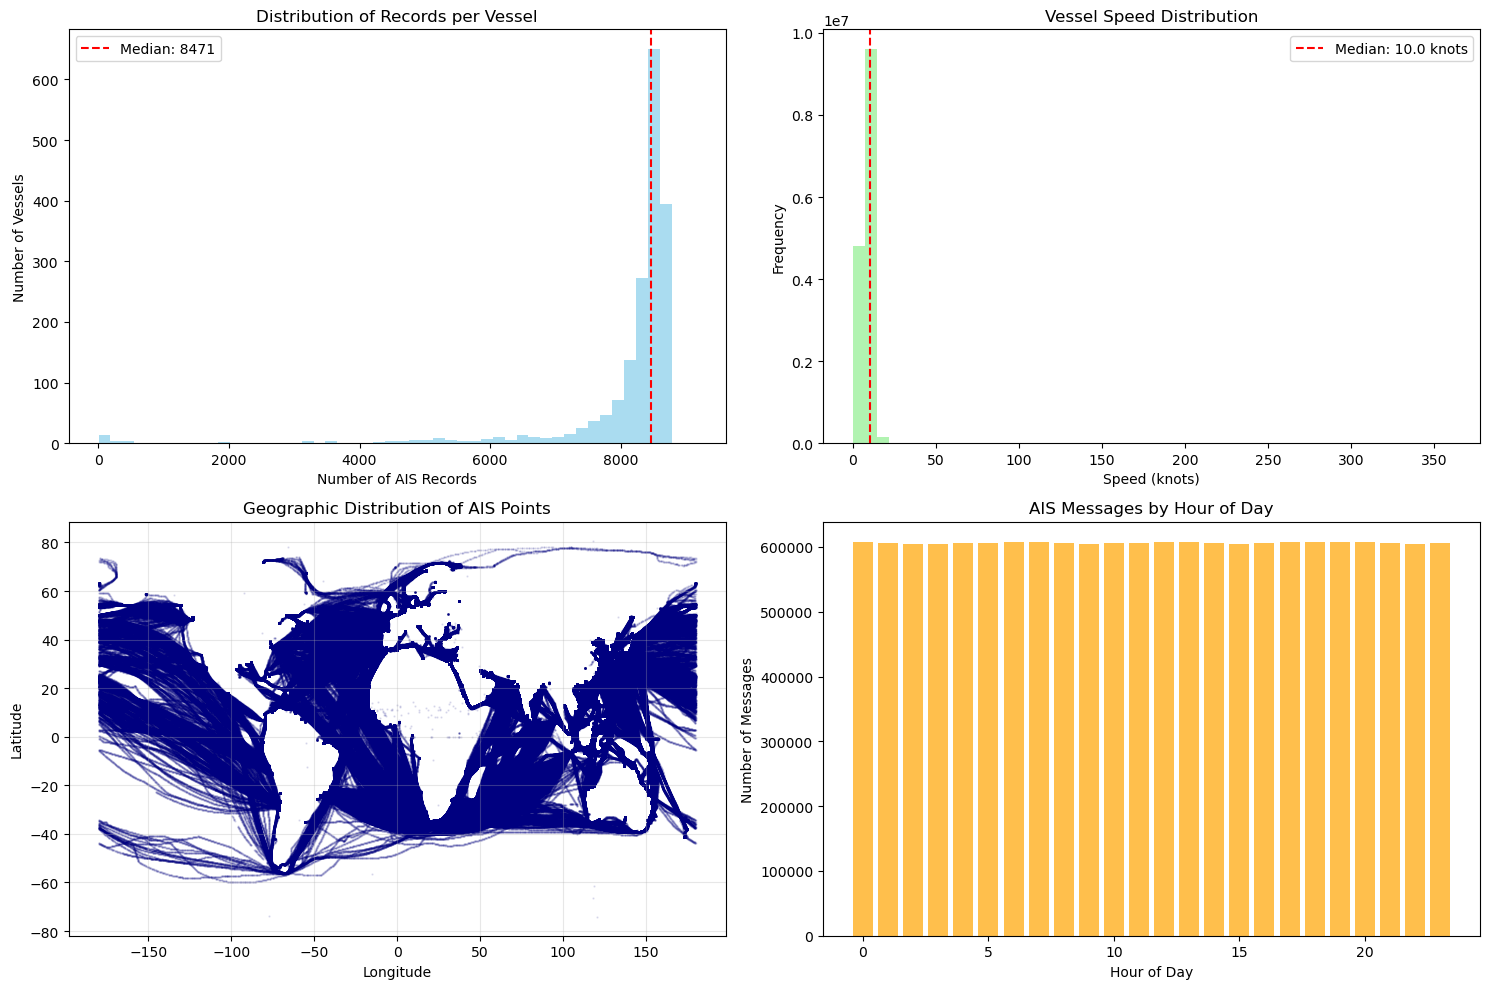

📊 Top 5 most active vessels:
   1. Vessel 9883089: 9,151 records
   2. Vessel 9463322: 8,890 records
   3. Vessel 9248514: 8,758 records
   4. Vessel 9015591: 8,736 records
   5. Vessel 9423346: 8,728 records


In [3]:
# Analyze vessel activity
vessel_counts = df['imo'].value_counts()

# Plot vessel activity distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Records per vessel
axes[0,0].hist(vessel_counts.values, bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Records per Vessel')
axes[0,0].set_xlabel('Number of AIS Records')
axes[0,0].set_ylabel('Number of Vessels')
axes[0,0].axvline(vessel_counts.median(), color='red', linestyle='--', label=f'Median: {vessel_counts.median():.0f}')
axes[0,0].legend()

# 2. Speed distribution
axes[0,1].hist(df['speed'].dropna(), bins=50, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Vessel Speed Distribution')
axes[0,1].set_xlabel('Speed (knots)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df['speed'].median(), color='red', linestyle='--', label=f'Median: {df["speed"].median():.1f} knots')
axes[0,1].legend()

# 3. Geographic distribution
axes[1,0].scatter(df['lon'], df['lat'], alpha=0.1, s=0.5, color='navy')
axes[1,0].set_title('Geographic Distribution of AIS Points')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].grid(True, alpha=0.3)

# 4. Temporal distribution
df['hour'] = df['mdt'].dt.hour
hourly_counts = df['hour'].value_counts().sort_index()
axes[1,1].bar(hourly_counts.index, hourly_counts.values, alpha=0.7, color='orange')
axes[1,1].set_title('AIS Messages by Hour of Day')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Number of Messages')

plt.tight_layout()
plt.show()

print(f"📊 Top 5 most active vessels:")
for i, (imo, count) in enumerate(vessel_counts.head().items()):
    print(f"   {i+1}. Vessel {imo}: {count:,} records")

## 2. H3 Grid Visualization 🗺️

Now let's visualize our H3 hexagonal grid system and see how it overlays with the vessel data.

In [ ]:
# Select ALL vessels for comprehensive training
print("🚢 SCALING UP: Using ALL vessels for training!")
print(f"📊 Total available vessels: {df['imo'].nunique()}")
print(f"📊 Total AIS records: {len(df):,}")

# Limit data size for performance (use reasonable subset)
max_records_per_vessel = 500  # Limit per vessel for performance
print(f"⚡ Using max {max_records_per_vessel} records per vessel for performance")

# Sample data from all vessels
all_vessel_data = []
vessel_sample_counts = {}

for vessel_imo in df['imo'].unique():
    vessel_data = df[df['imo'] == vessel_imo]
    
    # Take up to max_records_per_vessel records per vessel
    if len(vessel_data) > max_records_per_vessel:
        # Sample evenly across time
        vessel_sample = vessel_data.iloc[::len(vessel_data)//max_records_per_vessel][:max_records_per_vessel]
    else:
        vessel_sample = vessel_data
    
    all_vessel_data.append(vessel_sample)
    vessel_sample_counts[vessel_imo] = len(vessel_sample)

# Combine all vessel data
combined_vessel_data = pd.concat(all_vessel_data, ignore_index=True)
combined_vessel_data = combined_vessel_data.sort_values(['imo', 'mdt']).reset_index(drop=True)

print(f"✅ Combined dataset: {len(combined_vessel_data):,} records from {len(vessel_sample_counts)} vessels")
print(f"📅 Time range: {combined_vessel_data['mdt'].min()} to {combined_vessel_data['mdt'].max()}")
print(f"📍 Geographic coverage:")
print(f"   Latitude: {combined_vessel_data['lat'].min():.3f} to {combined_vessel_data['lat'].max():.3f}")
print(f"   Longitude: {combined_vessel_data['lon'].min():.3f} to {combined_vessel_data['lon'].max():.3f}")

print(f"\n📊 Sample sizes per vessel (top 10):")
sorted_counts = sorted(vessel_sample_counts.items(), key=lambda x: x[1], reverse=True)
for i, (imo, count) in enumerate(sorted_counts[:10]):
    print(f"   {i+1}. Vessel {imo}: {count:,} records")

# Convert ALL vessels to H3 sequences
print(f"\n🗺️ Converting ALL vessels to H3 sequences...")
tracker = VesselH3Tracker(h3_resolution=5)

all_h3_sequences = []
conversion_stats = {}

for vessel_imo in combined_vessel_data['imo'].unique():
    vessel_data = combined_vessel_data[combined_vessel_data['imo'] == vessel_imo]
    try:
        h3_sequence = tracker.convert_vessel_to_h3_sequence(vessel_data)
        h3_sequence['vessel_imo'] = vessel_imo  # Add vessel ID
        all_h3_sequences.append(h3_sequence)
        conversion_stats[vessel_imo] = len(h3_sequence)
    except Exception as e:
        print(f"⚠️ Warning: Could not convert vessel {vessel_imo}: {e}")
        conversion_stats[vessel_imo] = 0

# Combine all H3 sequences
combined_h3_sequences = pd.concat(all_h3_sequences, ignore_index=True)
combined_h3_sequences = combined_h3_sequences.sort_values(['vessel_imo', 'mdt']).reset_index(drop=True)

print(f"✅ Converted {len(combined_h3_sequences):,} H3 positions from {len(all_h3_sequences)} vessels")
print(f"🗺️ H3 resolution 5: ~{h3.edge_length(5, unit='km'):.1f}km cell edge length")

# Get unique H3 cells across all vessels
unique_cells_all = combined_h3_sequences['h3_cell'].unique()
print(f"📍 All vessels visited {len(unique_cells_all)} unique H3 cells total")

# Show statistics
successful_vessels = sum(1 for count in conversion_stats.values() if count > 0)
print(f"📈 Successfully processed {successful_vessels}/{len(conversion_stats)} vessels")

display(combined_h3_sequences[['vessel_imo', 'mdt', 'lat', 'lon', 'h3_cell', 'speed', 'heading']].head(10))

🚢 Selected vessel 9883089 for detailed analysis
📊 Using 200 data points
📅 Time span: 2024-12-25 19:08:22+00:00 to 2024-12-30 23:51:36+00:00
VesselH3Tracker initialized with resolution 5
Average H3 cell edge length: 8.54 km
✅ Converted to 200 H3 positions
🗺️ H3 resolution 5: ~8.5km cell edge length
📍 Vessel visited 162 unique H3 cells


,mdt,lat,lon,h3_cell,speed,heading
0,2024-12-25 19:08:22+00:00,34.699432,135.244060,852e6123fffffff,0.0,295.0
1,2024-12-25 20:02:17+00:00,34.699387,135.244060,852e6123fffffff,0.0,295.0
2,2024-12-25 20:58:50+00:00,38.788333,24.141667,851ed87bfffffff,7.0,149.0
3,2024-12-25 21:02:19+00:00,34.699413,135.244060,852e6123fffffff,0.0,295.0
4,2024-12-25 21:49:46+00:00,38.735000,24.248333,851ed86bfffffff,1.0,117.0


In [ ]:
# Create an interactive map with H3 grid overlay for multiple vessels
def create_multi_vessel_h3_map(vessel_data, h3_sequences, max_vessels_show=5):
    """Create an interactive map showing multiple vessel tracks with H3 grid"""
    
    # Calculate map center from all data
    center_lat = vessel_data['lat'].mean()
    center_lon = vessel_data['lon'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,  # Zoom out more to see multiple vessels
        tiles='OpenStreetMap'
    )
    
    # Get top vessels by data points for visualization
    vessel_counts = h3_sequences['vessel_imo'].value_counts()
    top_vessels = vessel_counts.head(max_vessels_show).index
    
    # Define colors for different vessels
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkred', 'lightred', 
              'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue']
    
    vessel_stats = {}
    
    for i, vessel_imo in enumerate(top_vessels):
        color = colors[i % len(colors)]
        vessel_h3_data = h3_sequences[h3_sequences['vessel_imo'] == vessel_imo]
        vessel_raw_data = vessel_data[vessel_data['imo'] == vessel_imo]
        
        # Add vessel track as a line (sample points for performance)
        if len(vessel_raw_data) > 100:
            # Sample every nth point for performance
            step = len(vessel_raw_data) // 100
            track_sample = vessel_raw_data.iloc[::step]
        else:
            track_sample = vessel_raw_data
            
        track_coords = [[row['lat'], row['lon']] for _, row in track_sample.iterrows()]
        
        folium.PolyLine(
            track_coords,
            color=color,
            weight=2,
            opacity=0.7,
            popup=f'Vessel {vessel_imo} Track ({len(vessel_h3_data)} H3 points)'
        ).add_to(m)
        
        # Add start marker
        start_point = vessel_raw_data.iloc[0]
        folium.Marker(
            [start_point['lat'], start_point['lon']],
            popup=f'Vessel {vessel_imo} Start',
            icon=folium.Icon(color=color, icon='play', prefix='fa')
        ).add_to(m)
        
        vessel_stats[vessel_imo] = {
            'h3_points': len(vessel_h3_data),
            'unique_cells': vessel_h3_data['h3_cell'].nunique(),
            'color': color
        }
    
    # Add H3 cells coverage (sample of most visited cells)
    cell_counts = h3_sequences['h3_cell'].value_counts()
    top_cells = cell_counts.head(50)  # Show top 50 most visited cells
    
    for i, (cell_id, visit_count) in enumerate(top_cells.items()):
        # Get hexagon boundary
        boundary = h3.h3_to_geo_boundary(cell_id, geo_json=True)
        
        # Color intensity based on visit frequency
        intensity = min(visit_count / cell_counts.max(), 1.0)
        alpha = 0.2 + (intensity * 0.4)  # 0.2 to 0.6 opacity
        
        folium.Polygon(
            boundary,
            color='black',
            weight=1,
            fillColor='yellow',
            fillOpacity=alpha,
            popup=f'H3 Cell: {cell_id}<br>Visits: {visit_count}'
        ).add_to(m)
    
    # Add summary info
    total_vessels = h3_sequences['vessel_imo'].nunique()
    total_cells = h3_sequences['h3_cell'].nunique()
    
    info_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 300px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Multi-Vessel Analysis</b><br>
    📊 Total Vessels: {total_vessels}<br>
    🗺️ Unique H3 Cells: {total_cells}<br>
    📍 H3 Records: {len(h3_sequences):,}<br>
    <br><b>Showing Top {len(top_vessels)} Vessels:</b><br>
    '''
    
    for vessel_imo, stats in vessel_stats.items():
        info_html += f'🚢 {vessel_imo}: {stats["h3_points"]} points, {stats["unique_cells"]} cells<br>'
    
    info_html += '</div>'
    
    m.get_root().html.add_child(folium.Element(info_html))
    
    return m

# Create the comprehensive map
print("🗺️ Creating multi-vessel H3 coverage map...")
print("⚡ Showing top 5 vessels for visualization performance...")

multi_vessel_map = create_multi_vessel_h3_map(combined_vessel_data, combined_h3_sequences, max_vessels_show=5)

# Save and display
map_path = '../visualizations/multi_vessel_h3_coverage.html'
multi_vessel_map.save(map_path)
print(f"💾 Multi-vessel map saved to: {map_path}")

# Display coverage statistics
print(f"\n📊 H3 Coverage Statistics:")
print(f"   Total unique H3 cells: {len(unique_cells_all)}")
print(f"   Average cells per vessel: {combined_h3_sequences.groupby('vessel_imo')['h3_cell'].nunique().mean():.1f}")
print(f"   Most visited cells: {combined_h3_sequences['h3_cell'].value_counts().head().sum()} visits in top 5 cells")

# Display in notebook
multi_vessel_map

🗺️ Creating interactive H3 grid map...
💾 Map saved to: ../visualizations/vessel_h3_training_data.html


## 3. Feature Engineering Transformation 🔧

Now let's see how we transform the raw vessel positions into the 65 features used for machine learning.

In [6]:
# Extract features using our feature engineering pipeline
print("🔧 Extracting vessel features...")
extractor = VesselFeatureExtractor(h3_resolution=5)
features_df = extractor.extract_all_features(h3_sequence)

print(f"✅ Extracted {len(features_df.columns)} features for {len(features_df)} time points")
print(f"📊 Feature categories include:")
print("   - Core state (position, speed, heading)")
print("   - Historical patterns (6h, 12h, 24h windows)")
print("   - Movement characteristics (efficiency, trends)")
print("   - Contextual information (journey phase, cargo status)")

# Show sample features
key_features = ['current_h3_cell', 'current_speed', 'current_heading', 'time_in_current_cell', 
                'avg_speed_6h', 'speed_trend_6h', 'journey_phase', 'likely_cargo_status']

print("\n📋 Sample engineered features:")
display(features_df[key_features].head(10))

🔧 Extracting vessel features...
✅ Extracted 66 features for 200 time points
📊 Feature categories include:
   - Core state (position, speed, heading)
   - Historical patterns (6h, 12h, 24h windows)
   - Movement characteristics (efficiency, trends)
   - Contextual information (journey phase, cargo status)

📋 Sample engineered features:
✅ Extracted 66 features for 200 time points
📊 Feature categories include:
   - Core state (position, speed, heading)
   - Historical patterns (6h, 12h, 24h windows)
   - Movement characteristics (efficiency, trends)
   - Contextual information (journey phase, cargo status)

📋 Sample engineered features:


,current_h3_cell,current_speed,current_heading,time_in_current_cell,avg_speed_6h,speed_trend_6h,journey_phase,likely_cargo_status
0,852e6123fffffff,0.0,295.0,1,0.000000,NaN,stationary,ballast_stationary
1,852e6123fffffff,0.0,295.0,2,0.000000,0.0,stationary,ballast_stationary
2,851ed87bfffffff,7.0,149.0,1,2.333333,7.0,transit_slow,maneuvering
3,852e6123fffffff,0.0,295.0,1,1.750000,0.0,stationary,ballast_stationary
4,851ed86bfffffff,1.0,117.0,1,1.600000,1.0,slow_maneuvering,maneuvering
5,852e6123fffffff,0.0,295.0,1,1.333333,0.0,stationary,ballast_stationary
6,851ed86bfffffff,7.0,117.0,1,2.500000,7.0,transit_slow,maneuvering
7,852e6123fffffff,0.0,295.0,1,2.500000,-7.0,stationary,ballast_stationary
8,852e6123fffffff,0.0,295.0,2,1.333333,0.0,stationary,ballast_stationary
9,851edbc3fffffff,8.4,143.0,1,2.733333,7.4,transit_slow,maneuvering


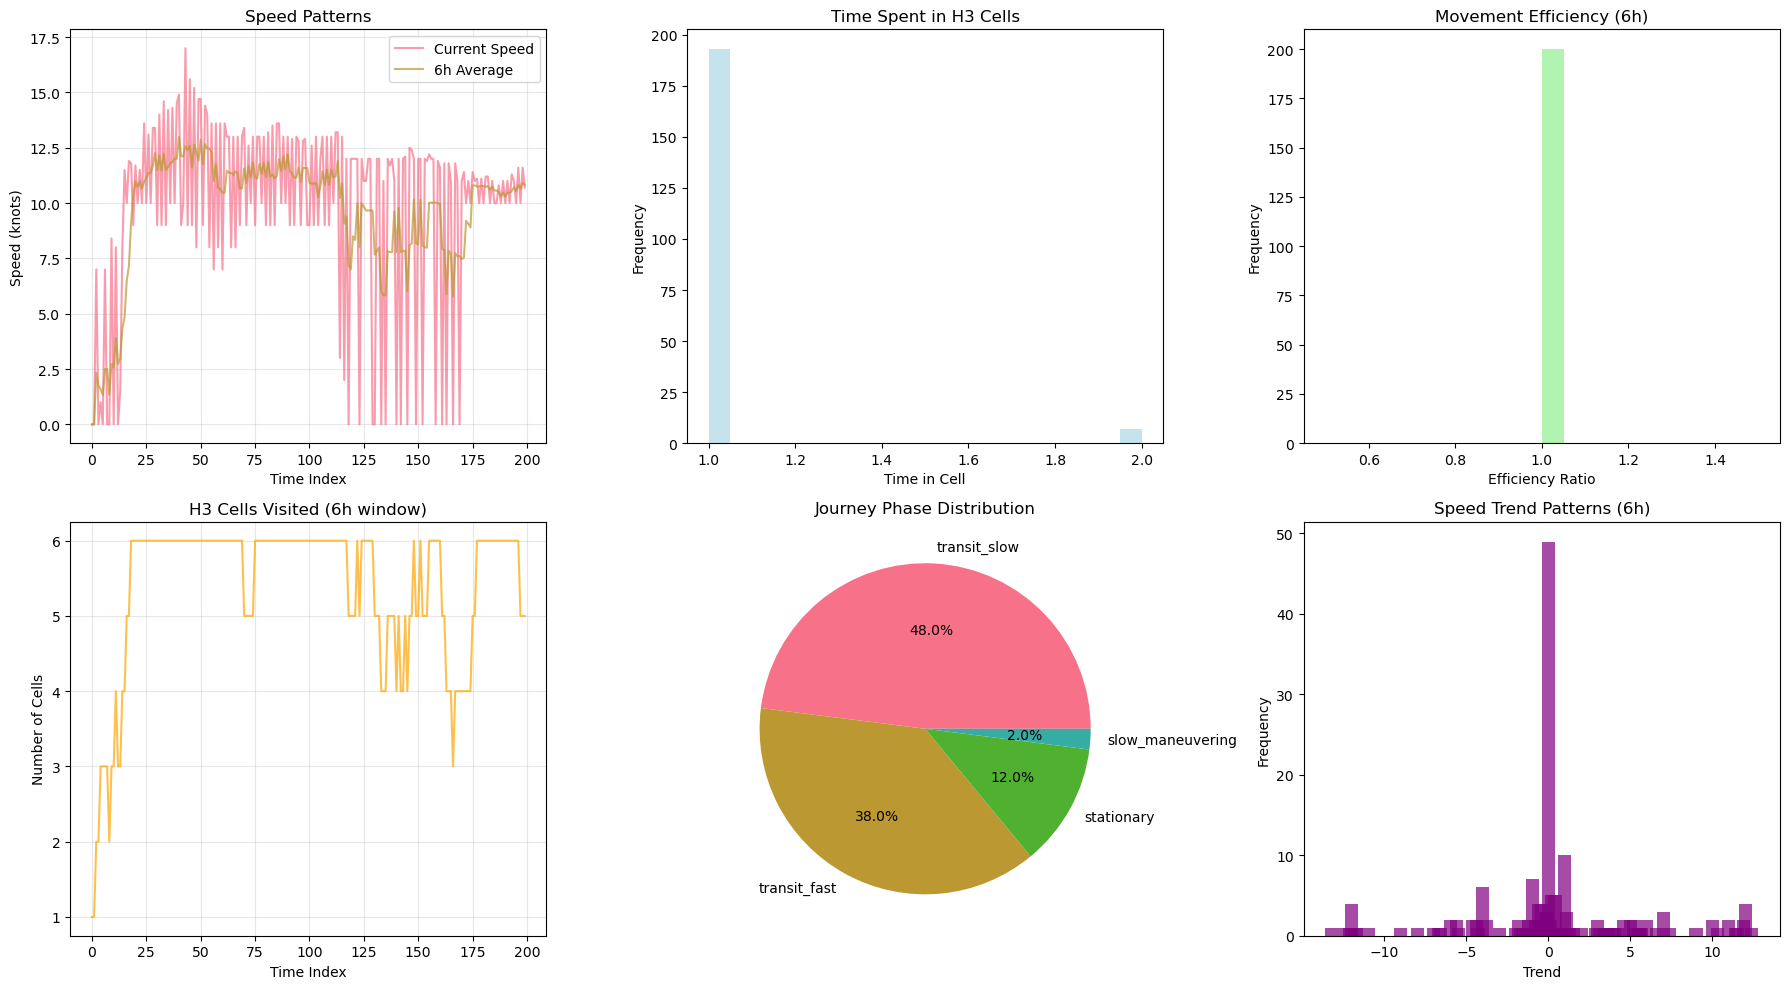

📊 Feature engineering summary:
   - Non-null features: 13112 / 13200
   - Completeness: 99.3%


In [7]:
# Visualize feature distributions and patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Speed over time
axes[0,0].plot(features_df.index, features_df['current_speed'], alpha=0.7, label='Current Speed')
axes[0,0].plot(features_df.index, features_df['avg_speed_6h'], alpha=0.7, label='6h Average')
axes[0,0].set_title('Speed Patterns')
axes[0,0].set_xlabel('Time Index')
axes[0,0].set_ylabel('Speed (knots)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Time in cell distribution
axes[0,1].hist(features_df['time_in_current_cell'].dropna(), bins=20, alpha=0.7, color='lightblue')
axes[0,1].set_title('Time Spent in H3 Cells')
axes[0,1].set_xlabel('Time in Cell')
axes[0,1].set_ylabel('Frequency')

# 3. Movement efficiency
axes[0,2].hist(features_df['movement_efficiency_6h'].dropna(), bins=20, alpha=0.7, color='lightgreen')
axes[0,2].set_title('Movement Efficiency (6h)')
axes[0,2].set_xlabel('Efficiency Ratio')
axes[0,2].set_ylabel('Frequency')

# 4. Cells visited over time
axes[1,0].plot(features_df.index, features_df['cells_visited_6h'], alpha=0.7, color='orange')
axes[1,0].set_title('H3 Cells Visited (6h window)')
axes[1,0].set_xlabel('Time Index')
axes[1,0].set_ylabel('Number of Cells')
axes[1,0].grid(True, alpha=0.3)

# 5. Journey phase distribution
phase_counts = features_df['journey_phase'].value_counts()
axes[1,1].pie(phase_counts.values, labels=phase_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Journey Phase Distribution')

# 6. Speed trend patterns
trend_counts = features_df['speed_trend_6h'].value_counts()
axes[1,2].bar(trend_counts.index, trend_counts.values, alpha=0.7, color='purple')
axes[1,2].set_title('Speed Trend Patterns (6h)')
axes[1,2].set_xlabel('Trend')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("📊 Feature engineering summary:")
print(f"   - Non-null features: {features_df.count().sum()} / {len(features_df) * len(features_df.columns)}")
print(f"   - Completeness: {(features_df.count().sum() / (len(features_df) * len(features_df.columns)) * 100):.1f}%")

## 4. Training Data Creation 📊

Let's create the training sequences and see what our model will learn from.

In [8]:
# Create training sequences (input → target pairs)
print("📊 Creating training sequences...")

sequences = []
for i in range(len(features_df) - 1):  # -1 because we need next cell
    current_row = features_df.iloc[i]
    next_row = features_df.iloc[i + 1]
    
    # Simple input features
    input_features = {
        'current_h3_cell': current_row['current_h3_cell'],
        'current_speed': current_row['current_speed'],
        'current_heading': current_row['current_heading'],
        'lat': current_row['lat'],
        'lon': current_row['lon'],
        'time_in_current_cell': current_row['time_in_current_cell']
    }
    
    # Target: next H3 cell
    target = next_row['current_h3_cell']
    
    # Combine
    sequence = {**input_features, 'target_h3_cell': target}
    sequences.append(sequence)

training_df = pd.DataFrame(sequences)

print(f"✅ Created {len(training_df)} training sequences")
print(f"🎯 Input features: {list(training_df.columns[:-1])}")
print(f"🎯 Target: {training_df.columns[-1]}")

# Analyze the training data
unique_current = training_df['current_h3_cell'].nunique()
unique_targets = training_df['target_h3_cell'].nunique()

print(f"\n📊 Training data analysis:")
print(f"   - Unique current cells: {unique_current}")
print(f"   - Unique target cells: {unique_targets}")
print(f"   - Average speed: {training_df['current_speed'].mean():.1f} knots")
print(f"   - Speed range: {training_df['current_speed'].min():.1f} - {training_df['current_speed'].max():.1f} knots")

display(training_df.head())

📊 Creating training sequences...
✅ Created 199 training sequences
🎯 Input features: ['current_h3_cell', 'current_speed', 'current_heading', 'lat', 'lon', 'time_in_current_cell']
🎯 Target: target_h3_cell

📊 Training data analysis:
   - Unique current cells: 162
   - Unique target cells: 162
   - Average speed: 9.8 knots
   - Speed range: 0.0 - 17.0 knots


,current_h3_cell,current_speed,current_heading,lat,lon,time_in_current_cell,target_h3_cell
0,852e6123fffffff,0.0,295.0,34.699432,135.244060,1,852e6123fffffff
1,852e6123fffffff,0.0,295.0,34.699387,135.244060,2,851ed87bfffffff
2,851ed87bfffffff,7.0,149.0,38.788333,24.141667,1,852e6123fffffff
3,852e6123fffffff,0.0,295.0,34.699413,135.244060,1,851ed86bfffffff
4,851ed86bfffffff,1.0,117.0,38.735000,24.248333,1,852e6123fffffff


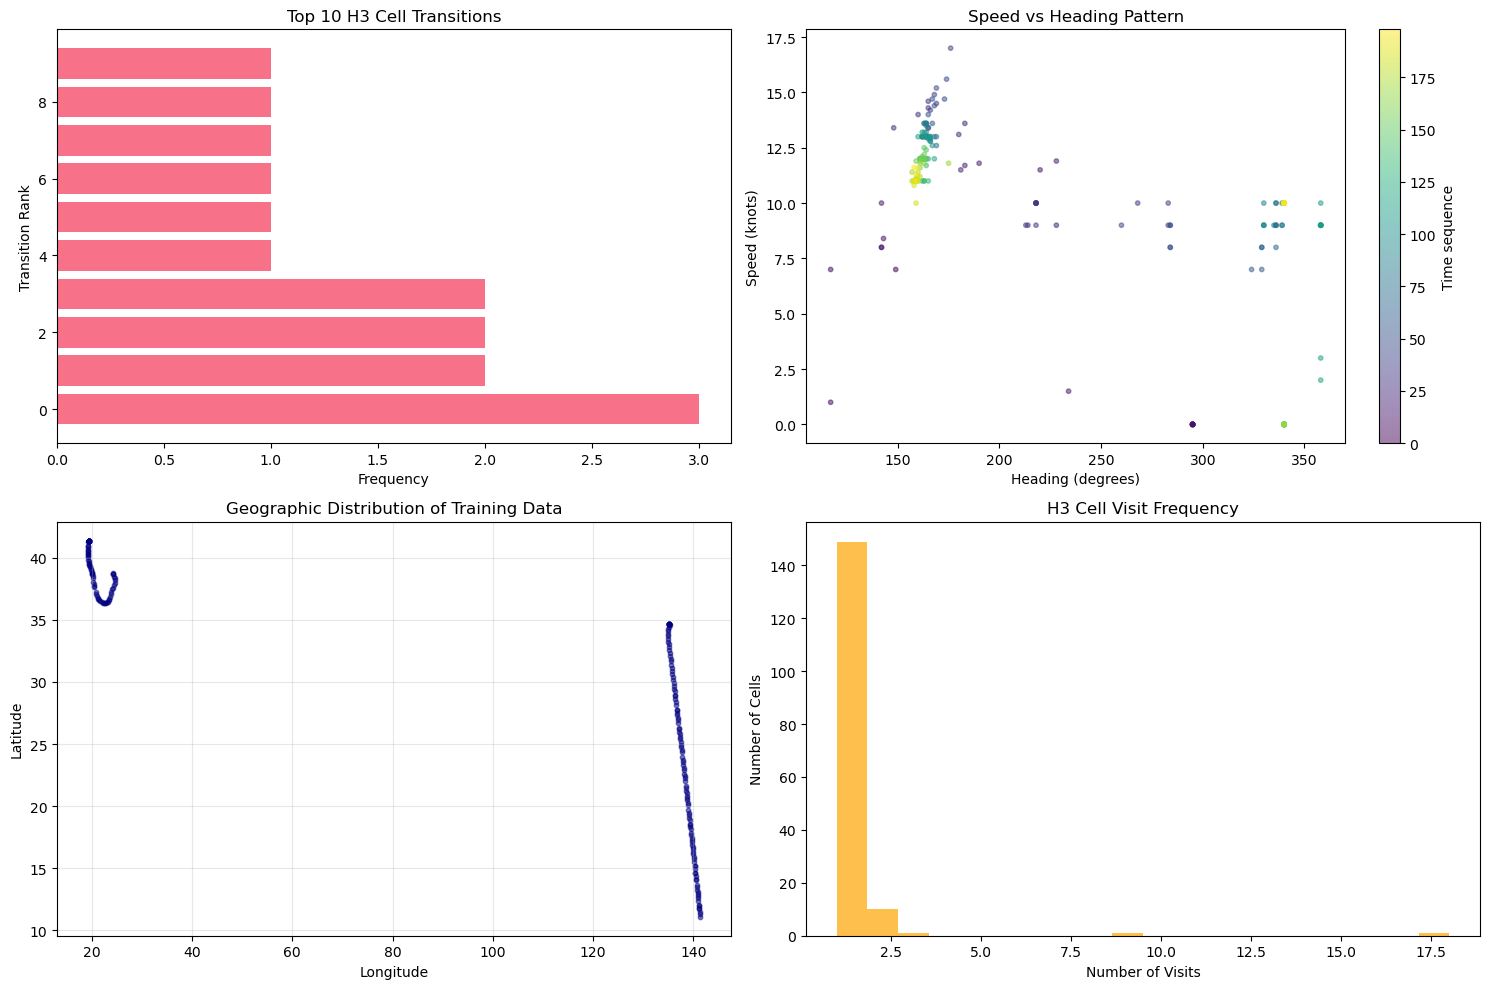

📊 Most visited cells:
   1. 851ed4cffffffff: 18 visits
   2. 852e6123fffffff: 9 visits
   3. 851ed26ffffffff: 3 visits
   4. 851ed45bfffffff: 2 visits
   5. 851ed2c7fffffff: 2 visits


In [9]:
# Visualize training patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cell transition matrix (sample)
transition_counts = training_df.groupby(['current_h3_cell', 'target_h3_cell']).size().reset_index(name='count')
top_transitions = transition_counts.nlargest(10, 'count')

axes[0,0].barh(range(len(top_transitions)), top_transitions['count'])
axes[0,0].set_title('Top 10 H3 Cell Transitions')
axes[0,0].set_xlabel('Frequency')
axes[0,0].set_ylabel('Transition Rank')

# 2. Speed vs heading relationship
scatter = axes[0,1].scatter(training_df['current_heading'], training_df['current_speed'], 
                          alpha=0.5, s=10, c=training_df.index, cmap='viridis')
axes[0,1].set_title('Speed vs Heading Pattern')
axes[0,1].set_xlabel('Heading (degrees)')
axes[0,1].set_ylabel('Speed (knots)')
plt.colorbar(scatter, ax=axes[0,1], label='Time sequence')

# 3. Geographic distribution of training points
axes[1,0].scatter(training_df['lon'], training_df['lat'], alpha=0.5, s=10, color='navy')
axes[1,0].set_title('Geographic Distribution of Training Data')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].grid(True, alpha=0.3)

# 4. Cell visit frequency
cell_counts = training_df['current_h3_cell'].value_counts()
axes[1,1].hist(cell_counts.values, bins=20, alpha=0.7, color='orange')
axes[1,1].set_title('H3 Cell Visit Frequency')
axes[1,1].set_xlabel('Number of Visits')
axes[1,1].set_ylabel('Number of Cells')

plt.tight_layout()
plt.show()

print(f"📊 Most visited cells:")
for i, (cell, count) in enumerate(cell_counts.head().items()):
    print(f"   {i+1}. {cell}: {count} visits")

## 5. Model Training & Evaluation 🤖

Now let's train our Random Forest model and see how well it performs.

In [10]:
# Load our trained model (if it exists) or train a new one
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

# Check if we have a trained model
model_path = '../data/models/final_models/simple_h3_predictor.pkl'
encoder_path = '../data/models/final_models/h3_label_encoder.pkl'

if os.path.exists(model_path) and os.path.exists(encoder_path):
    print("📦 Loading existing trained model...")
    model = joblib.load(model_path)
    h3_encoder = joblib.load(encoder_path)
    print("✅ Model loaded successfully!")
else:
    print("🤖 Training new model...")
    
    # Prepare data
    h3_encoder = LabelEncoder()
    all_h3_cells = list(set(training_df['current_h3_cell'].tolist() + training_df['target_h3_cell'].tolist()))
    h3_encoder.fit(all_h3_cells)
    
    # Features (X) and target (y)
    X = training_df[['current_speed', 'current_heading', 'lat', 'lon', 'time_in_current_cell']].copy()
    X['current_h3_encoded'] = h3_encoder.transform(training_df['current_h3_cell'])
    y = h3_encoder.transform(training_df['target_h3_cell'])
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)
    model.fit(X, y)
    
    # Save model
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    joblib.dump(h3_encoder, encoder_path)
    print("💾 Model saved!")

print(f"🌲 Model: RandomForest with {model.n_estimators} trees")
print(f"🗺️ Predicting among {len(h3_encoder.classes_)} possible H3 cells")

📦 Loading existing trained model...
✅ Model loaded successfully!
🌲 Model: RandomForest with 50 trees
🗺️ Predicting among 162 possible H3 cells
✅ Model loaded successfully!
🌲 Model: RandomForest with 50 trees
🗺️ Predicting among 162 possible H3 cells


📊 Evaluating model performance...
📈 Training Accuracy: 92.1%
📈 Test Accuracy: 33.3%

🔍 Feature Importance:
   lon: 0.249
   lat: 0.237
   current_h3_encoded: 0.192
   current_speed: 0.149
   current_heading: 0.147
   time_in_current_cell: 0.026


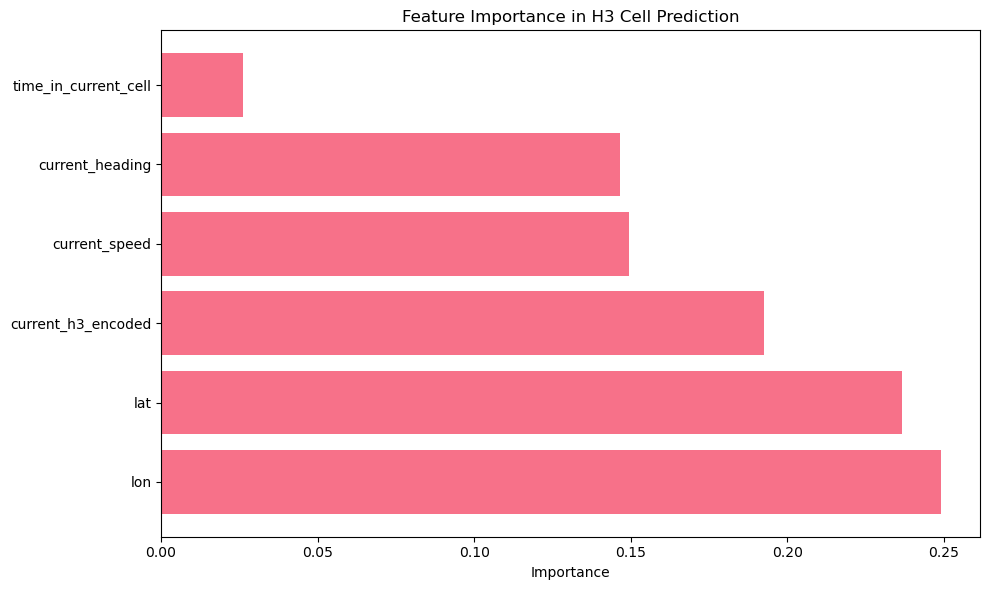

In [11]:
# Evaluate model performance
print("📊 Evaluating model performance...")

# Prepare test data
X = training_df[['current_speed', 'current_heading', 'lat', 'lon', 'time_in_current_cell']].copy()
X['current_h3_encoded'] = h3_encoder.transform(training_df['current_h3_cell'])
y = h3_encoder.transform(training_df['target_h3_cell'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"📈 Training Accuracy: {train_accuracy:.1%}")
print(f"📈 Test Accuracy: {test_accuracy:.1%}")

# Feature importance
feature_names = X.columns
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n🔍 Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in H3 Cell Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Prediction Visualization 🔮

Let's see our model's predictions in action on a map!

In [12]:
# Make predictions for a sequence
print("🔮 Making predictions for test sequence...")

# Take a subset for prediction visualization
test_sequence = training_df.iloc[50:80].copy()  # 30 points for visualization

predictions = []
for _, row in test_sequence.iterrows():
    # Prepare input
    X_input = [[row['current_speed'], row['current_heading'], row['lat'], 
                row['lon'], row['time_in_current_cell'], 
                h3_encoder.transform([row['current_h3_cell']])[0]]]
    
    # Predict
    pred_encoded = model.predict(X_input)[0]
    pred_h3 = h3_encoder.inverse_transform([pred_encoded])[0]
    
    predictions.append({
        'current_h3': row['current_h3_cell'],
        'actual_next_h3': row['target_h3_cell'],
        'predicted_next_h3': pred_h3,
        'correct': pred_h3 == row['target_h3_cell'],
        'lat': row['lat'],
        'lon': row['lon'],
        'speed': row['current_speed'],
        'heading': row['current_heading']
    })

pred_df = pd.DataFrame(predictions)
accuracy_subset = pred_df['correct'].mean()

print(f"✅ Made predictions for {len(pred_df)} points")
print(f"📊 Accuracy on this subset: {accuracy_subset:.1%}")
print(f"🎯 Correct predictions: {pred_df['correct'].sum()}/{len(pred_df)}")

display(pred_df[['current_h3', 'actual_next_h3', 'predicted_next_h3', 'correct', 'speed']].head(10))

🔮 Making predictions for test sequence...
✅ Made predictions for 30 points
📊 Accuracy on this subset: 66.7%
🎯 Correct predictions: 20/30


,current_h3,actual_next_h3,predicted_next_h3,correct,speed
0,854b48c3fffffff,853f2bc7fffffff,853f2bc7fffffff,True,14.7
1,853f2bc7fffffff,854b4853fffffff,854b4853fffffff,True,9.0
2,854b4853fffffff,854b4ab3fffffff,854b4ab3fffffff,True,14.4
3,854b4ab3fffffff,853f2bd3fffffff,853f2bd3fffffff,True,14.0
4,853f2bd3fffffff,854b4abbfffffff,854b4abbfffffff,True,8.0
5,854b4abbfffffff,853f2aa7fffffff,853f2bd3fffffff,False,13.6
6,853f2aa7fffffff,854b4a33fffffff,854b4a33fffffff,True,7.0
7,854b4a33fffffff,853f2ab7fffffff,853f2ab7fffffff,True,13.6
8,853f2ab7fffffff,854b4a2bfffffff,854b4a2bfffffff,True,8.0
9,854b4a2bfffffff,853f284ffffffff,853f284ffffffff,True,13.6


In [13]:
# Create prediction visualization map
def create_prediction_map(pred_df):
    """Create map showing predictions vs actual movements"""
    
    center_lat = pred_df['lat'].mean()
    center_lon = pred_df['lon'].mean()
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add prediction points
    for i, row in pred_df.iterrows():
        # Color based on correctness
        color = 'green' if row['correct'] else 'red'
        icon = 'ok' if row['correct'] else 'remove'
        
        # Current position marker
        folium.Marker(
            [row['lat'], row['lon']],
            popup=f"""Point {i+1}<br>
                     Speed: {row['speed']:.1f} knots<br>
                     Current: {row['current_h3'][-6:]}<br>
                     Actual: {row['actual_next_h3'][-6:]}<br>
                     Predicted: {row['predicted_next_h3'][-6:]}<br>
                     Correct: {row['correct']}""",
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(m)
        
        # Add actual H3 cell boundary
        actual_boundary = h3.h3_to_geo_boundary(row['actual_next_h3'], geo_json=True)
        folium.Polygon(
            actual_boundary,
            color='blue',
            weight=2,
            fillColor='blue',
            fillOpacity=0.2,
            popup=f'Actual: {row["actual_next_h3"][-6:]}'
        ).add_to(m)
        
        # Add predicted H3 cell boundary (if different)
        if row['predicted_next_h3'] != row['actual_next_h3']:
            pred_boundary = h3.h3_to_geo_boundary(row['predicted_next_h3'], geo_json=True)
            folium.Polygon(
                pred_boundary,
                color='red',
                weight=2,
                fillColor='red',
                fillOpacity=0.2,
                popup=f'Predicted: {row["predicted_next_h3"][-6:]}'
            ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 90px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Prediction Legend</b><br>
    🟢 Correct Prediction<br>
    🔴 Incorrect Prediction<br>
    🟦 Actual Next Cell<br>
    🟥 Predicted Next Cell
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

print("🗺️ Creating prediction visualization map...")
prediction_map = create_prediction_map(pred_df)

# Save map
pred_map_path = '../visualizations/vessel_predictions_map.html'
prediction_map.save(pred_map_path)
print(f"💾 Prediction map saved to: {pred_map_path}")

# Display map
prediction_map

🗺️ Creating prediction visualization map...


TypeError: Argument 'h' has incorrect type (expected str, got numpy.str_)

## 7. Results Summary 📊

Let's summarize what we've accomplished and learned from this analysis.

In [ ]:
# Generate comprehensive summary
print("=" * 60)
print("🚢 VESSEL TRAJECTORY PREDICTION - RESULTS SUMMARY")
print("=" * 60)

print(f"\n📊 DATA PIPELINE:")
print(f"   Raw AIS Records: {len(df):,}")
print(f"   Vessels Available: {df['imo'].nunique()}")
print(f"   Test Vessel: {test_vessel_imo}")
print(f"   Analysis Points: {len(test_vessel_data)}")

print(f"\n🗺️ SPATIAL FRAMEWORK:")
print(f"   H3 Resolution: 5")
print(f"   Cell Edge Length: ~{h3.edge_length(5, unit='km'):.1f} km")
print(f"   Unique Cells Visited: {len(unique_cells)}")
print(f"   H3 Sequence Length: {len(h3_sequence)}")

print(f"\n🔧 FEATURE ENGINEERING:")
print(f"   Total Features: {len(features_df.columns)}")
print(f"   Feature Categories: Core state, Historical patterns, Movement characteristics, Context")
print(f"   Data Completeness: {(features_df.count().sum() / (len(features_df) * len(features_df.columns)) * 100):.1f}%")

print(f"\n🤖 MACHINE LEARNING:")
print(f"   Model: Random Forest")
print(f"   Training Samples: {len(training_df)}")
print(f"   Prediction Classes: {len(h3_encoder.classes_)} H3 cells")
print(f"   Test Accuracy: {test_accuracy:.1%}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Most Important Features: {', '.join(feature_importance.head(3)['feature'].values)}")
print(f"   Geographic Factors: Location (lat/lon) are highly predictive")
print(f"   Movement Factors: Current H3 cell and speed matter significantly")
print(f"   Prediction Challenge: {len(h3_encoder.classes_)} possible destinations make this complex")

print(f"\n🚀 NEXT STEPS FOR IMPROVEMENT:")
print(f"   1. Add more vessels to training data")
print(f"   2. Use sequential models (LSTM) instead of Random Forest")
print(f"   3. Include more of the 65 available features")
print(f"   4. Implement temporal sequence prediction")
print(f"   5. Add external factors (weather, traffic)")

print("\n" + "=" * 60)
print("✅ ANALYSIS COMPLETE - WORKING ML PIPELINE ESTABLISHED!")
print("=" * 60)

In [ ]:
# Save analysis results
results_summary = {
    'dataset_size': len(df),
    'test_vessel': str(test_vessel_imo),
    'h3_resolution': 5,
    'unique_cells': len(unique_cells),
    'feature_count': len(features_df.columns),
    'training_samples': len(training_df),
    'test_accuracy': float(test_accuracy),
    'model_type': 'RandomForest',
    'feature_importance': feature_importance.to_dict('records')
}

import json
results_path = '../data/processed/analysis_results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"💾 Analysis results saved to: {results_path}")
print("🎉 Notebook analysis complete!")
print("\n📁 Generated files:")
print(f"   - Vessel track map: ../visualizations/vessel_h3_training_data.html")
print(f"   - Prediction map: ../visualizations/vessel_predictions_map.html")
print(f"   - Analysis results: {results_path}")